In [1]:
import pandas as pd
import nltk.data
import re
import scipy.stats as st
import numpy as np
import itertools
from collections import Counter

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim.utils import simple_preprocess
from nltk import bigrams as nltkbigrams
from gensim.corpora.dictionary import Dictionary

# Graphic libraries
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
sns.set_theme()

# Dataset

In [2]:
# Load English reviews dataset
df = pd.read_csv('input/english_reviews_v2.csv')
# Convert all text in pre processed reviews into lower case
df['text_n'] = df['text_n'].str.lower()
df.head()

,createdDate,stayDate,hotelName,rating,helpfulVotes,text,tripType,parentGeo,text_n
0,2020-07-14,2020-02-29,Hana Riverside Villa,4,0,"Hana Riverside Quang Ngai hotel, - Located in ...",NONE,Quảng Ngãi,hana riverside quang ngai hotel located in a q...
1,2020-02-18,2020-02-29,Hana Riverside Villa,5,0,Dropped in here for 1 night on my way north. F...,SOLO,Quảng Ngãi,dropped in here for 1 night on my way north. f...
2,2019-09-17,2019-09-30,Hana Riverside Villa,4,0,Stayed here for one night while passing throug...,COUPLES,Quảng Ngãi,stayed here for one night while passing throug...
3,2018-10-04,2018-09-30,Hana Riverside Villa,5,0,Kinda difficult to find but we had a great sta...,COUPLES,Quảng Ngãi,kind of difficult to find but we had a great s...
4,2020-03-10,2020-03-31,Cocoland River Beach Resort & Spa,1,1,Don’t go to this place. The manager is a liar....,COUPLES,Quảng Ngãi,do not go to this place. the manager is a liar...


In [5]:
df['text'][2]

"Stayed here for one night while passing through. The room was clean and tidy and had a kettle and fridge which was good. Nice clean modern bathroom. It wasn't in the best location for us to find something for dinner if you're after anything other than standard local food. The bed was comfy, our main issue was just that we got repeatedly woken up all night by a dog barking very close by and was allowed to continue barking all night and in the early hours of the morning. Very frustrating but if that hadnt been a problem, then no issues with the accommodation."

## Aspect list

In [129]:
# Import the list of aspects and words bank
aspect_df = pd.read_csv('input/Aspect_List.csv')
# Remove duplicates
aspect_df = aspect_df.drop_duplicates()

# Creating a dataframe with aspect numbers and names
aspect_list_df = aspect_df.groupby(['aspect', 'aspect_no']).nunique().reset_index()
aspect_list_df= aspect_list_df.sort_values('aspect_no').reset_index(drop = True)
aspect_list_df = aspect_list_df.set_index('aspect_no')
aspect_list_df

,aspect,keywords
aspect_no,,
1,Location,44
2,Cleanliness,34
3,Comfort,24
4,Facilities,84
5,Service,102
6,Value,17
7,Food_and_beverage,54


## Tokenisation

In [109]:
# import stopwords
stop_words = stopwords.words('english')
# Additional stop words
stop_words = stop_words + ['etc'] 

# Remove words for negation from the words list
words_to_remove = ['no', 'not', 'very']
for word in words_to_remove:
    try:
        stop_words.remove(word)
    except:
        print("Word '"+ word + "' not in the list")

# Load sentence tokenizer
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

wnl = WordNetLemmatizer()

# Preprocessing of Reviews

def extract_tokens(review):
    # Convert a document into a list of tokens
    # This lowercases, tokenizes, removes numerical values
    all_tokens = []
    sentences = sent_detector.tokenize(review)
    for sentence in sentences:
        tokens = simple_preprocess(sentence)
        # Apply POS tagging
        pos_tags = pos_tag(tokens)

        sent_tokens = []

        for word, tag in pos_tags:
            if word not in stop_words:
                # Check if the word is a verb
                if tag.startswith('V'):
                    # Lemmatize the verb (get base form)
                    lemma = WordNetLemmatizer().lemmatize(word, pos='v')
                    sent_tokens.append(lemma)
                elif tag.startswith('N'):
                    # Lemmatize the noun (get base form)
                    lemma = WordNetLemmatizer().lemmatize(word, pos='n')
                    sent_tokens.append(lemma)
                elif tag.startswith('J'):
                    # Lemmatize the adjective (get base form)
                    lemma = WordNetLemmatizer().lemmatize(word, pos='a')
                    sent_tokens.append(lemma)
                elif tag.startswith('R'):
                    # Lemmatize the adverb (get base form)
                    lemma = WordNetLemmatizer().lemmatize(word, pos='r')
                    sent_tokens.append(lemma)
                else:
                    sent_tokens.append(word)  # Keep the rest of tokens as is

        all_tokens.append(sent_tokens)
    return(all_tokens)


# Add tokens columns to the dataframe
df['tokens'] = df['text_n'].apply(lambda x: extract_tokens(x))


# Print out infromation about articles and number of tokens for top 15
print('Tokens groups created:', df.tokens.notna().sum(),'\n')

df.head()

Tokens groups created: 32449 



,createdDate,stayDate,hotelName,rating,helpfulVotes,text,tripType,parentGeo,text_n,tokens
0,2020-07-14,2020-02-29,Hana Riverside Villa,4,0,"Hana Riverside Quang Ngai hotel, - Located in ...",NONE,Quảng Ngãi,hana riverside quang ngai hotel located in a q...,"[[hana, riverside, quang, ngai, hotel, locate,..."
1,2020-02-18,2020-02-29,Hana Riverside Villa,5,0,Dropped in here for 1 night on my way north. F...,SOLO,Quảng Ngãi,dropped in here for 1 night on my way north. f...,"[[drop, night, way, north], [friendly, helpful..."
2,2019-09-17,2019-09-30,Hana Riverside Villa,4,0,Stayed here for one night while passing throug...,COUPLES,Quảng Ngãi,stayed here for one night while passing throug...,"[[stay, one, night, pass], [room, clean, tidy,..."
3,2018-10-04,2018-09-30,Hana Riverside Villa,5,0,Kinda difficult to find but we had a great sta...,COUPLES,Quảng Ngãi,kind of difficult to find but we had a great s...,"[[kind, difficult, find, great, stay], [place,..."
4,2020-03-10,2020-03-31,Cocoland River Beach Resort & Spa,1,1,Don’t go to this place. The manager is a liar....,COUPLES,Quảng Ngãi,do not go to this place. the manager is a liar...,"[[not, go, place], [manager, liar], [first, re..."


## Number of symbols and words in a review

In [7]:
# Function to return number of symbols in text review
# Input: text string
# Output integer
def number_of_symbols(review):
    no_symbols = len(review)
    return(no_symbols)

# Function to return number of words in text review
# Input: text string
# Output integer
def number_of_words(review):
    no_words = len(simple_preprocess(review))
    return(no_words)

In [110]:
# Calculate nuber of symbols, words, and sentences in original review
df['no_symbols'] = df['text'].apply(lambda x: number_of_symbols(x))
df['no_words'] = df['text'].apply(lambda x: number_of_words(x))
df['no_sentences'] = df['text'].apply(lambda x: len(sent_detector.tokenize(x)))
df[['no_symbols', 'no_words', 'no_sentences']].describe()

,no_symbols,no_words,no_sentences
count,32449.000000,32449.000000,32449.000000
mean,802.398626,140.363709,9.229098
std,801.680488,141.001467,8.008418
min,63.000000,10.000000,1.000000
25%,322.000000,56.000000,5.000000
50%,552.000000,96.000000,7.000000
75%,973.000000,171.000000,11.000000
max,20269.000000,3483.000000,189.000000


In [115]:
# Function calulates confidence interval (by default at 95% level)
# Input: array of numeric values
# Output: prints mean value, confidence interval and min / max boundry values
def conf_interval(array, conf_level = 0.95):
    ci_scale = st.t.interval(confidence = conf_level, 
                  df = len(array) - 1, 
                  loc = np.mean(array),  
                  scale = st.sem(array))
    print('Confidence interval with 0.95% conf level:', round(np.mean(array),2), ' +/-', round(np.mean(array) - ci_scale[0],2))
    print('Min:', str(round(ci_scale[0], 2)), '; Max:', round(ci_scale[1],2) )

In [116]:
conf_interval(df['no_symbols'])

Confidence interval with 0.95% conf level: 802.4  +/- 8.72
Min: 793.68 ; Max: 811.12


In [117]:
conf_interval(df['no_words'])

Confidence interval with 0.95% conf level: 140.36  +/- 1.53
Min: 138.83 ; Max: 141.9


In [118]:
conf_interval(df['no_sentences'])

Confidence interval with 0.95% conf level: 9.23  +/- 0.09
Min: 9.14 ; Max: 9.32


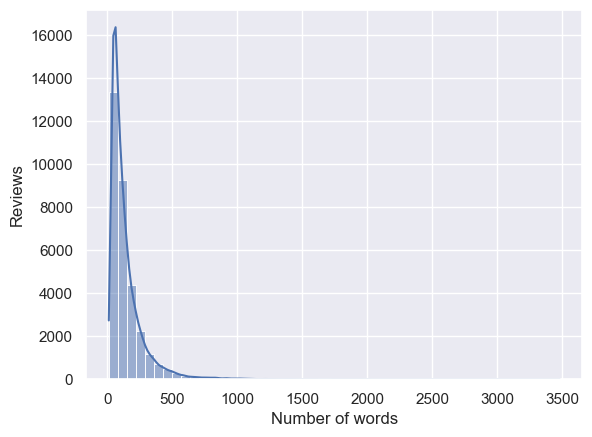

In [119]:
# Histogram for number of words
sns.histplot(df["no_words"], kde=True, bins = 50)
plt.xlabel('Number of words')
plt.ylabel('Reviews')
plt.show()

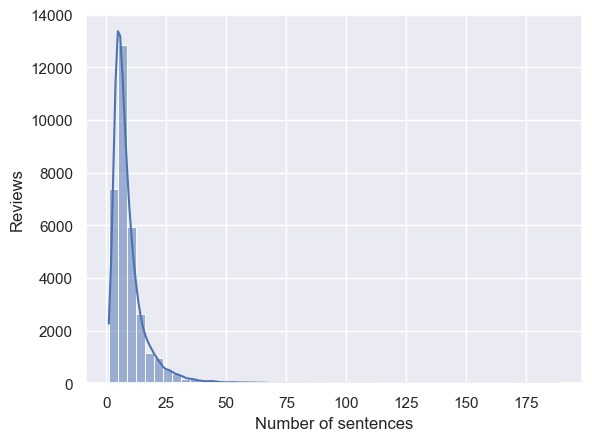

In [120]:
# Histogram for number of sentences
sns.histplot(df["no_sentences"], kde=True, bins = 50)
plt.xlabel('Number of sentences')
plt.ylabel('Reviews')
plt.show()

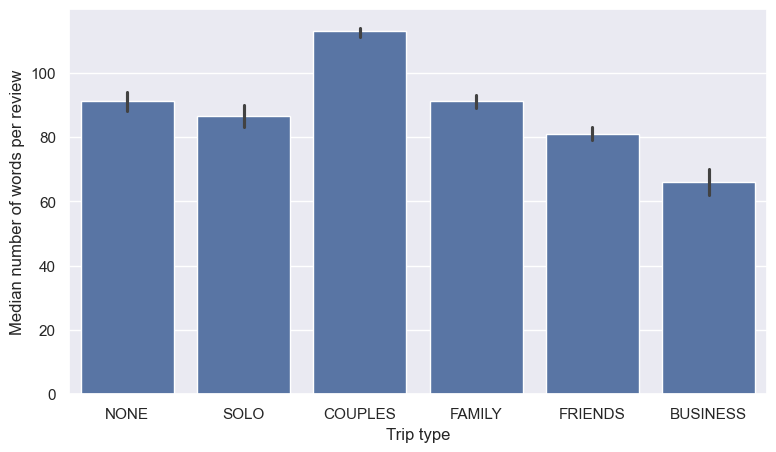

In [121]:
# Median number of words per review by trip type - bar plot
plt.figure(figsize=(9,5))
ax = sns.barplot(df, x='tripType', y="no_words", estimator=np.median)
ax.set_ylabel('Median number of words per review')
ax.set_xlabel('Trip type')
plt.show()

In [123]:
# Median number of words per review by trip type
df[['tripType', 'no_words']].groupby('tripType').median()

,no_words
tripType,
BUSINESS,66.0
COUPLES,113.0
FAMILY,91.0
FRIENDS,81.0
NONE,91.0
SOLO,86.5


# Birgams 

In [124]:
# Create a list of bigrams based on tokens
bigrams = [list(nltkbigrams(list(itertools.chain(*review)))) for review in df.tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*bigrams))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the answers:', len(bigram_counts))

# Dataframe with bigrams sorted by frequency
bigram_df = pd.DataFrame(bigram_counts.most_common(300), columns=['bigram', 'count'])
bigram_df.head(20)

Number of unique bigrams in the answers: 806045


,bigram,count
0,"(very, good)",3209
1,"(come, back)",3133
2,"(staff, very)",2720
3,"(very, nice)",2681
4,"(could, not)",2600
5,"(highly, recommend)",2551
6,"(phu, quoc)",2481
7,"(very, friendly)",2426
8,"(phong, nha)",2155
9,"(stay, night)",1908


In [15]:
# Export top 300 bigrams to CSV
bigram_df.to_csv("output/english_bigrams_300.csv", index = False, header = True)

In [125]:
# Function to replace tokens with bigrams join by underscore: (one, night) -> one_night
# Input: review - list of lists of tokens in a review;
# bigrams - list of tuples e.g. ('let', 'us')
# Output: list of lists of tokens with bigram matches replaced by two words joint by underscore
# based on https://stackoverflow.com/questions/47906952/how-to-replace-bigrams-in-place-using-nltk
def bigram_replacement(review, bigrams):
    lookup = set(bigrams)
    all_tokens = []

    for sentence in review:
        tokens = []
        q_iter = iter(range(len(sentence)))
        for idx in q_iter:
            tokens.append(sentence[idx])
            if idx < (len(sentence) - 1) and (sentence[idx], sentence[idx+1]) in lookup:
                tokens[-1] += "_" + sentence[idx+1]
                next(q_iter)
        all_tokens.append(tokens)
    return(all_tokens)

In [130]:
# Top-300 bigrams
top_n = bigram_df['bigram'].iloc[:300]

# Adding a column with joint tokens based on bigrams
df['tokens_j'] = df['tokens'].apply(lambda x: bigram_replacement(x, top_n))
df.head()

,createdDate,stayDate,hotelName,rating,helpfulVotes,text,tripType,parentGeo,text_n,tokens,no_symbols,no_words,no_sentences,tokens_j
0,2020-07-14,2020-02-29,Hana Riverside Villa,4,0,"Hana Riverside Quang Ngai hotel, - Located in ...",NONE,Quảng Ngãi,hana riverside quang ngai hotel located in a q...,"[[hana, riverside, quang, ngai, hotel, locate,...",365,60,6,"[[hana, riverside, quang, ngai, hotel, locate,..."
1,2020-02-18,2020-02-29,Hana Riverside Villa,5,0,Dropped in here for 1 night on my way north. F...,SOLO,Quảng Ngãi,dropped in here for 1 night on my way north. f...,"[[drop, night, way, north], [friendly, helpful...",205,34,4,"[[drop, night, way, north], [friendly_helpful,..."
2,2019-09-17,2019-09-30,Hana Riverside Villa,4,0,Stayed here for one night while passing throug...,COUPLES,Quảng Ngãi,stayed here for one night while passing throug...,"[[stay, one, night, pass], [room, clean, tidy,...",563,102,6,"[[stay_one, night, pass], [room_clean, tidy, k..."
3,2018-10-04,2018-09-30,Hana Riverside Villa,5,0,Kinda difficult to find but we had a great sta...,COUPLES,Quảng Ngãi,kind of difficult to find but we had a great s...,"[[kind, difficult, find, great, stay], [place,...",200,39,4,"[[kind, difficult, find, great_stay], [place, ..."
4,2020-03-10,2020-03-31,Cocoland River Beach Resort & Spa,1,1,Don’t go to this place. The manager is a liar....,COUPLES,Quảng Ngãi,do not go to this place. the manager is a liar...,"[[not, go, place], [manager, liar], [first, re...",1061,199,21,"[[not_go, place], [manager, liar], [first, rec..."


# Search for aspects from the list

In [126]:
# Function to detect aspect words in a list of tokens and save them in to a list
# if no askpect words are detected the ist is empty
# Input: review - list of list of tokens
#        aspect_words - list of words that identify aspect
# Output: list of aspect words found
def aspect_word_detection(review, aspect_words):
    aspect_tokens = []
    for sent in review:
        common_words = set(sent) & set(aspect_words)
        if len(common_words) > 0:
            aspect_tokens = aspect_tokens + list(common_words)
    if len(aspect_tokens) == 0:
        aspect_tokens = 0
    return(aspect_tokens)

In [131]:
# Going through all aspects and searching for askect words in in reviews
for index,row in aspect_list_df.iterrows():
    # Select a particuar aspect
    aspect_words = list(aspect_df[aspect_df['aspect_no'] == index]['keywords'])
    
    new_column_name = row['aspect'].lower()
    # Apply the function to the 'tokens' column using vectorization
    df[new_column_name] = df['tokens_j'].apply(aspect_word_detection, args=(aspect_words,))
df.head()

,createdDate,stayDate,hotelName,rating,helpfulVotes,text,tripType,parentGeo,text_n,tokens,...,no_words,no_sentences,tokens_j,location,cleanliness,comfort,facilities,service,value,food_and_beverage
0,2020-07-14,2020-02-29,Hana Riverside Villa,4,0,"Hana Riverside Quang Ngai hotel, - Located in ...",NONE,Quảng Ngãi,hana riverside quang ngai hotel located in a q...,"[[hana, riverside, quang, ngai, hotel, locate,...",...,60,6,"[[hana, riverside, quang, ngai, hotel, locate,...","[river, area, city]","[clean, dusty]","[quiet, sleep, night]","[villa, hotel, spacious, room, hotel]",[friendly_staff],0,0
1,2020-02-18,2020-02-29,Hana Riverside Villa,5,0,Dropped in here for 1 night on my way north. F...,SOLO,Quảng Ngãi,dropped in here for 1 night on my way north. f...,"[[drop, night, way, north], [friendly, helpful...",...,34,4,"[[drop, night, way, north], [friendly_helpful,...",0,[clean],"[night, night]","[spacious, room]","[staff, friendly_helpful]",0,[seafood]
2,2019-09-17,2019-09-30,Hana Riverside Villa,4,0,Stayed here for one night while passing throug...,COUPLES,Quảng Ngãi,stayed here for one night while passing throug...,"[[stay, one, night, pass], [room, clean, tidy,...",...,102,6,"[[stay_one, night, pass], [room_clean, tidy, k...",[location],"[tidy, room_clean, nice_clean]","[night, bed, wake, comfy, night]","[bathroom, accommodation]",0,0,"[food, dinner]"
3,2018-10-04,2018-09-30,Hana Riverside Villa,5,0,Kinda difficult to find but we had a great sta...,COUPLES,Quảng Ngãi,kind of difficult to find but we had a great s...,"[[kind, difficult, find, great, stay], [place,...",...,39,4,"[[kind, difficult, find, great_stay], [place, ...","[place, city, far, city]",0,0,0,"[kind, staff]",0,[food]
4,2020-03-10,2020-03-31,Cocoland River Beach Resort & Spa,1,1,Don’t go to this place. The manager is a liar....,COUPLES,Quảng Ngãi,do not go to this place. the manager is a liar...,"[[not, go, place], [manager, liar], [first, re...",...,199,21,"[[not_go, place], [manager, liar], [first, rec...","[place, far]",0,[comfortable],"[bungalow, view, bungalow, pool]","[manager, person, reception, manager, service]","[expensive, expensive, price, pay, price, pric...",[food]


In [132]:
# Reviews with no aspect
condition = (df['location'] == 0) & (df['cleanliness'] == 0) & (df['comfort'] == 0) & (df['facilities'] == 0) & (df['service'] == 0) & (df['value'] == 0) & (df['food_and_beverage'] == 0)

no_aspect = len(df[condition])
print('Number of reviews without aspects identified:', no_aspect)
print('Reviews without aspects identified from total:', round(no_aspect*100 / len(df), 2), "%")

for review in df[condition]['text']:
    print('\n', review )

Number of reviews without aspects identified: 27
Reviews without aspects identified from total: 0.08 %

 I was only halfway my bicycle trip that day, but the nice atmosphere kept me from going further. I had to stay at coco beachresort! Thnx for changing my schedule;) they have nice backpacker dollardeals. keep up the good work!

 If possible this trip is a must do. A great finish to our independent cycling tour dropped with our biked in central HCMC! Interesting and exciting with boats everywhere almost like HCMC traffic except on water. Such an adventure the highlight of our cycling trip to SE Asia.

 I believe this is the best place to stay, especially when the weather is nice. It has a great holiday feeling. The people are the best. Hostes Lam, Tao and Sun are lovely, they really want to help you and have a great time. Also, try the BBQ! It's amazing.

 We had the pleasure of following yoga in a small class. Anastasia is a wonderful teacher. She encouraged us with the yoga practice

In [133]:
# Reviews with all 7 aspects
condition = (df['location'] != 0) & (df['cleanliness'] != 0) & (df['comfort'] != 0) & (df['facilities'] != 0) & (df['service'] != 0) & (df['value'] != 0) & (df['food_and_beverage'] != 0)

all_aspects = len(df[condition])
print('Number of reviews with all 7 aspects identified:', all_aspects)
print('Reviews with all aspects identified from total:', round(all_aspects*100 / len(df), 2), "%")

Number of reviews with all 7 aspects identified: 2115
Reviews with all aspects identified from total: 6.52 %


In [134]:
# Function that calculates number of aspects in a particular review
# Input: a row of a dataframe
# Output: integer numer of reviews

def number_of_aspects(row):
    aspects_in_review = 0

    if (row['location'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['cleanliness'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['comfort'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['facilities'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['service'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['value'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['food_and_beverage'] != 0):
        aspects_in_review = aspects_in_review + 1

    return(aspects_in_review)

In [135]:
# Apply function to add as column with number of aspects identified
df['aspect_no'] = df.apply(number_of_aspects, axis = 1)
df.head()

,createdDate,stayDate,hotelName,rating,helpfulVotes,text,tripType,parentGeo,text_n,tokens,...,no_sentences,tokens_j,location,cleanliness,comfort,facilities,service,value,food_and_beverage,aspect_no
0,2020-07-14,2020-02-29,Hana Riverside Villa,4,0,"Hana Riverside Quang Ngai hotel, - Located in ...",NONE,Quảng Ngãi,hana riverside quang ngai hotel located in a q...,"[[hana, riverside, quang, ngai, hotel, locate,...",...,6,"[[hana, riverside, quang, ngai, hotel, locate,...","[river, area, city]","[clean, dusty]","[quiet, sleep, night]","[villa, hotel, spacious, room, hotel]",[friendly_staff],0,0,5
1,2020-02-18,2020-02-29,Hana Riverside Villa,5,0,Dropped in here for 1 night on my way north. F...,SOLO,Quảng Ngãi,dropped in here for 1 night on my way north. f...,"[[drop, night, way, north], [friendly, helpful...",...,4,"[[drop, night, way, north], [friendly_helpful,...",0,[clean],"[night, night]","[spacious, room]","[staff, friendly_helpful]",0,[seafood],5
2,2019-09-17,2019-09-30,Hana Riverside Villa,4,0,Stayed here for one night while passing throug...,COUPLES,Quảng Ngãi,stayed here for one night while passing throug...,"[[stay, one, night, pass], [room, clean, tidy,...",...,6,"[[stay_one, night, pass], [room_clean, tidy, k...",[location],"[tidy, room_clean, nice_clean]","[night, bed, wake, comfy, night]","[bathroom, accommodation]",0,0,"[food, dinner]",5
3,2018-10-04,2018-09-30,Hana Riverside Villa,5,0,Kinda difficult to find but we had a great sta...,COUPLES,Quảng Ngãi,kind of difficult to find but we had a great s...,"[[kind, difficult, find, great, stay], [place,...",...,4,"[[kind, difficult, find, great_stay], [place, ...","[place, city, far, city]",0,0,0,"[kind, staff]",0,[food],3
4,2020-03-10,2020-03-31,Cocoland River Beach Resort & Spa,1,1,Don’t go to this place. The manager is a liar....,COUPLES,Quảng Ngãi,do not go to this place. the manager is a liar...,"[[not, go, place], [manager, liar], [first, re...",...,21,"[[not_go, place], [manager, liar], [first, rec...","[place, far]",0,[comfortable],"[bungalow, view, bungalow, pool]","[manager, person, reception, manager, service]","[expensive, expensive, price, pay, price, pric...",[food],6


In [136]:
# Descriptive statistics for number of aspects
df['aspect_no'].describe()

count    32449.000000
mean         4.600481
std          1.343113
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: aspect_no, dtype: float64

In [137]:
# 95% confidence interval for mean
conf_interval(df['aspect_no'])

Confidence interval with 0.95% conf level: 4.6  +/- 0.01
Min: 4.59 ; Max: 4.62


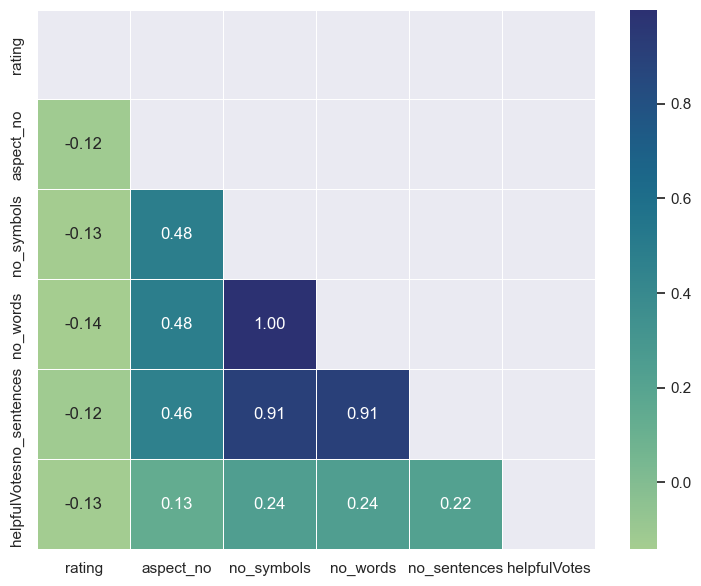

In [138]:
# Correlation matrix
corr = df[['rating', 'aspect_no','no_symbols', 'no_words', 'no_sentences', 'helpfulVotes']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(9,7))
sns.heatmap(corr, mask = mask, annot=True, fmt=".2f", cmap="crest", linewidth=.5)
plt.xticks(rotation=0)
plt.grid(visible = None)
plt.show()

## Aspect frequency

In [139]:
aspect_columns = ['location', 'cleanliness', 'comfort', 'facilities', 'service', 'value',
       'food_and_beverage']
# Total number of reviews
no_of_reviews = len(df)

aspect_frequencies = []
aspect_shares = []

for column in aspect_columns:
    # Number of columns where an aspect is present
    aspect_present = len(df[df[column] != 0])
    aspect_frequencies.append(aspect_present)
    aspect_share = round((aspect_present *100)/no_of_reviews,2)
    aspect_shares.append(aspect_share)
    print('Aspect', column, 'is present in', aspect_share, '% of reviews' )

aspect_frequency_df = pd.DataFrame()
aspect_frequency_df['aspect'] = aspect_columns
aspect_frequency_df['frequency'] = aspect_frequencies
aspect_frequency_df['share'] = aspect_shares

aspect_frequency_df

Aspect location is present in 80.32 % of reviews
Aspect cleanliness is present in 28.14 % of reviews
Aspect comfort is present in 56.99 % of reviews
Aspect facilities is present in 91.58 % of reviews
Aspect service is present in 91.2 % of reviews
Aspect value is present in 34.52 % of reviews
Aspect food_and_beverage is present in 77.3 % of reviews


,aspect,frequency,share
0,location,26062,80.32
1,cleanliness,9130,28.14
2,comfort,18492,56.99
3,facilities,29718,91.58
4,service,29595,91.20
5,value,11200,34.52
6,food_and_beverage,25084,77.30


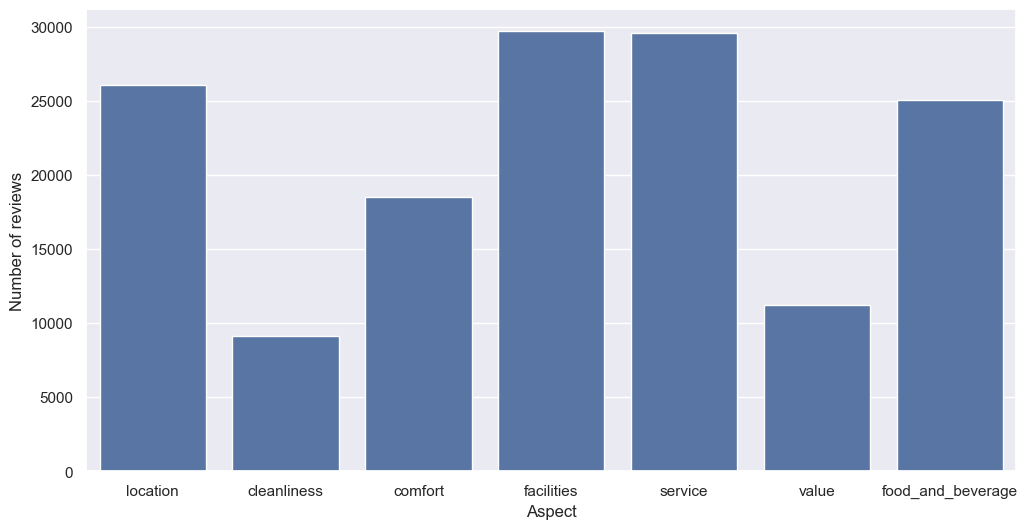

In [140]:
# Bar plot of aspect frequency
plt.figure(figsize=(12,6))
ax = sns.barplot(aspect_frequency_df, x="aspect", y="frequency")
#ax.set_title('Aspect frequency in all reviews')
ax.set_ylabel('Number of reviews')
ax.set_xlabel('Aspect')
plt.show()

In [ ]:
# What are the most popular words within each category?
# How many reviews have 0 aspects? how many reviews have all 4 aspects?
# How many aspects has a review on average.

In [141]:
# Aspect frequency and share by trip type
trip_types = list(df['tripType'].unique())
aspect_columns = ['location', 'cleanliness', 'comfort', 'facilities', 'service', 'value',
       'food_and_beverage']

for trtype in trip_types:
    trtype_df = df[df['tripType'] == trtype]
    
    # Total number of reviews per trip type
    no_of_reviews = len(trtype_df)

    aspect_frequencies = []
    aspect_shares = []

    for column in aspect_columns:
        # Number of columns where an aspect is present
        aspect_present = len(trtype_df[trtype_df[column] != 0])
        aspect_frequencies.append(aspect_present)
        aspect_share = round((aspect_present *100)/no_of_reviews,2)
        aspect_shares.append(aspect_share)
        #print('For trip type', trtype ,'aspect', column, 'is present in', aspect_share, '% of reviews' )
    
    column_freq_name = trtype.lower() + '_freq'
    column_share_name = trtype.lower() + '_share'
    aspect_frequency_df[column_freq_name] = aspect_frequencies
    aspect_frequency_df[column_share_name] = aspect_shares

aspect_frequency_df

,aspect,frequency,share,none_freq,none_share,solo_freq,solo_share,couples_freq,couples_share,family_freq,family_share,friends_freq,friends_share,business_freq,business_share
0,location,26062,80.32,3289,80.12,1665,81.06,10945,83.21,5900,77.88,3532,78.47,731,68.96
1,cleanliness,9130,28.14,1128,27.48,642,31.26,3747,28.49,2008,26.50,1294,28.75,311,29.34
2,comfort,18492,56.99,2220,54.08,1263,61.49,8227,62.55,3771,49.78,2507,55.70,504,47.55
3,facilities,29718,91.58,3794,92.42,1781,86.71,12266,93.26,6932,91.50,3986,88.56,959,90.47
4,service,29595,91.20,3700,90.13,1851,90.12,12170,92.53,6932,91.50,4040,89.76,902,85.09
5,value,11200,34.52,1328,32.35,752,36.61,5264,40.02,2237,29.53,1367,30.37,252,23.77
6,food_and_beverage,25084,77.30,3102,75.57,1476,71.86,10639,80.89,5755,75.96,3381,75.12,731,68.96


In [188]:
# Export aspect frequncy to CSV
aspect_frequency_df.to_csv("output/aspect_frequency_V2.csv", index = False, header = True)

### Analysis of aspects by trip type

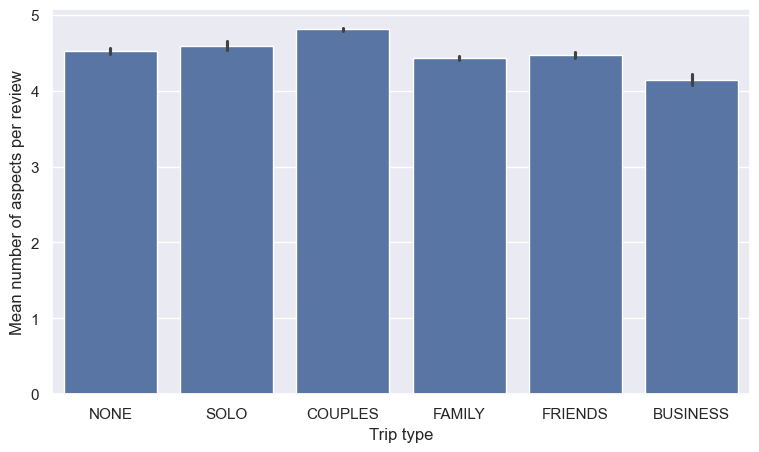

In [142]:
# Average number of aspects by trip type - plot
plt.figure(figsize=(9,5))
ax = sns.barplot(df, x='tripType', y="aspect_no", estimator=np.mean)
ax.set_ylabel('Mean number of aspects per review')
ax.set_xlabel('Trip type')
plt.show()

In [143]:
# Average number of aspects by trip type
df[['tripType', 'aspect_no']].groupby('tripType').mean()

,aspect_no
tripType,
BUSINESS,4.141509
COUPLES,4.809397
FAMILY,4.426478
FRIENDS,4.467230
NONE,4.521559
SOLO,4.591042


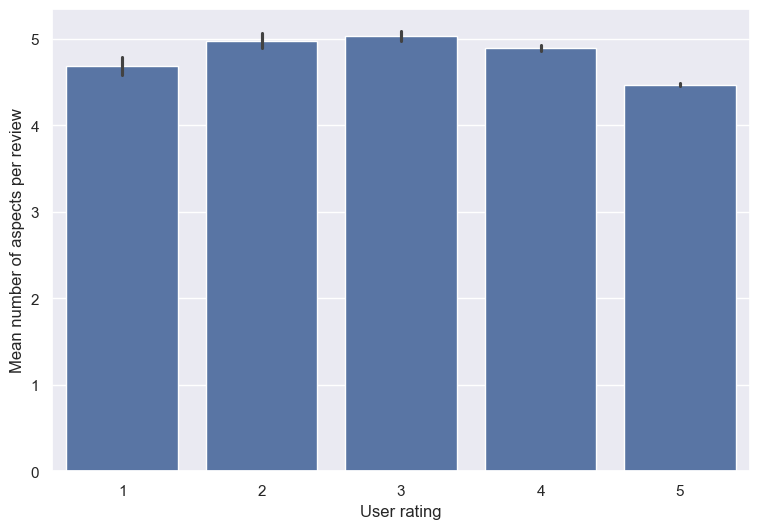

In [145]:
# Average number of aspects by user rating - plot
plt.figure(figsize=(9,6))
ax = sns.barplot(df, x="rating", y="aspect_no")
ax.set_ylabel('Mean number of aspects per review')
ax.set_xlabel('User rating')
plt.show()

In [144]:
# Average number of aspects by user rating
df[['rating', 'aspect_no']].groupby('rating').mean()

,aspect_no
rating,
1,4.687356
2,4.982724
3,5.036019
4,4.898235
5,4.472818


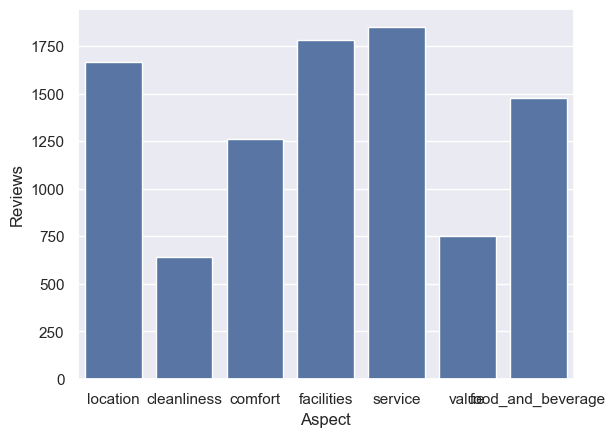

In [149]:
# Aspect frequency per trip type (for Solo travellers)
ax = sns.barplot(aspect_frequency_df, x="aspect", y="solo_freq")
ax.set_ylabel('Reviews')
ax.set_xlabel('Aspect')
plt.show()

### Analysis of aspects by accommodation category

In [151]:
# Dataframe with hotel names, accommodation type (category) and English name
hotels_df = pd.read_csv('input/accom_categories_combined.csv')
hotels_df = hotels_df.drop_duplicates(subset=['hotelName'])
hotels_df = hotels_df.reset_index(drop = True)
hotels_df = hotels_df.rename(columns={"Type": "accom_type", "English Name": "eng_name"})
print('Number of accommodations:', len(hotels_df))
hotels_df.head()

Number of accommodations: 946


,tripType,hotelName,Count,accom_type,Stars,eng_name
0,COUPLES,Khách sạn Nam Hải Hội An,1024,Resort,5.0,"Four Seasons Resort The Nam Hai, Hoi An"
1,COUPLES,Banyan Tree Lang Co,651,Resort,5.0,Banyan Tree Lang Co
2,FAMILY,Angsana Lang Co Vietnam,579,Resort,5.0,Angsana Lang Co Vietnam
3,COUPLES,Six Senses Ninh Van Bay,554,Resort,5.0,Six Senses Ninh Van Bay
4,COUPLES,Phong Nha Farmstay,550,Homestay / Farmstay / House / Lodge / Eco,NaN,Phong Nha Farmstay


In [153]:
# Number of accommodations and reviews by category
accom_count = hotels_df[['hotelName', 'accom_type']].groupby('accom_type').count()
accom_count = accom_count.rename(columns={"hotelName": "Count"})
accom_count.index.names = ['Accommodation Category']
accom_count['Reviews'] = hotels_df[['Count', 'accom_type']].groupby('accom_type').sum()
accom_count = accom_count.sort_values('Count', ascending = False)
accom_count

,Count,Reviews
Accommodation Category,,
Hotel,386,2504
Homestay / Farmstay / House / Lodge / Eco,238,2589
Resort,156,9500
Guesthouse / Hostel,62,473
Bungalow / Villa / Retreat,39,490


In [154]:
# Adding accommodation category and translated hotel name to dataframe
df = df.merge(hotels_df[['hotelName', 'accom_type', 'eng_name']], on='hotelName', how='left')
df.head()

,createdDate,stayDate,hotelName,rating,helpfulVotes,text,tripType,parentGeo,text_n,tokens,...,location,cleanliness,comfort,facilities,service,value,food_and_beverage,aspect_no,accom_type,eng_name
0,2020-07-14,2020-02-29,Hana Riverside Villa,4,0,"Hana Riverside Quang Ngai hotel, - Located in ...",NONE,Quảng Ngãi,hana riverside quang ngai hotel located in a q...,"[[hana, riverside, quang, ngai, hotel, locate,...",...,"[river, area, city]","[clean, dusty]","[quiet, sleep, night]","[villa, hotel, spacious, room, hotel]",[friendly_staff],0,0,5,Bungalow / Villa / Retreat,Hana Riverside Villa
1,2020-02-18,2020-02-29,Hana Riverside Villa,5,0,Dropped in here for 1 night on my way north. F...,SOLO,Quảng Ngãi,dropped in here for 1 night on my way north. f...,"[[drop, night, way, north], [friendly, helpful...",...,0,[clean],"[night, night]","[spacious, room]","[staff, friendly_helpful]",0,[seafood],5,Bungalow / Villa / Retreat,Hana Riverside Villa
2,2019-09-17,2019-09-30,Hana Riverside Villa,4,0,Stayed here for one night while passing throug...,COUPLES,Quảng Ngãi,stayed here for one night while passing throug...,"[[stay, one, night, pass], [room, clean, tidy,...",...,[location],"[tidy, room_clean, nice_clean]","[night, bed, wake, comfy, night]","[bathroom, accommodation]",0,0,"[food, dinner]",5,Bungalow / Villa / Retreat,Hana Riverside Villa
3,2018-10-04,2018-09-30,Hana Riverside Villa,5,0,Kinda difficult to find but we had a great sta...,COUPLES,Quảng Ngãi,kind of difficult to find but we had a great s...,"[[kind, difficult, find, great, stay], [place,...",...,"[place, city, far, city]",0,0,0,"[kind, staff]",0,[food],3,Bungalow / Villa / Retreat,Hana Riverside Villa
4,2020-03-10,2020-03-31,Cocoland River Beach Resort & Spa,1,1,Don’t go to this place. The manager is a liar....,COUPLES,Quảng Ngãi,do not go to this place. the manager is a liar...,"[[not, go, place], [manager, liar], [first, re...",...,"[place, far]",0,[comfortable],"[bungalow, view, bungalow, pool]","[manager, person, reception, manager, service]","[expensive, expensive, price, pay, price, pric...",[food],6,Resort,Cocoland River Beach Resort & Spa


In [172]:
# Create a dataframe with aggregated data for treeplot
treeplot_df = df[['accom_type','tripType', 'text', 'hotelName']].groupby(['accom_type','tripType']).nunique()
treeplot_df['avg_rating'] = df[['accom_type','tripType', 'rating']].groupby(['accom_type','tripType']).mean()
treeplot_df['avg_aspect'] = df[['accom_type','tripType', 'aspect_no']].groupby(['accom_type','tripType']).mean()
treeplot_df = treeplot_df.rename(columns={"text": "reviews", "hotelName": "hotels"})
treeplot_df = treeplot_df.reset_index()
treeplot_df.head()

,accom_type,tripType,reviews,hotels,avg_rating,avg_aspect
0,Bungalow / Villa / Retreat,BUSINESS,17,7,4.058824,4.352941
1,Bungalow / Villa / Retreat,COUPLES,443,33,4.467269,4.772009
2,Bungalow / Villa / Retreat,FAMILY,171,21,4.192982,4.573099
3,Bungalow / Villa / Retreat,FRIENDS,223,24,4.497758,4.439462
4,Bungalow / Villa / Retreat,NONE,173,30,4.502890,4.630058


In [178]:
# https://plotly.com/python/treemaps/
data = treeplot_df
fig = px.treemap(data, path=[px.Constant("All accommodation"), 'accom_type', 'tripType'], values='reviews',
                  color='avg_rating', #hover_data=['tripType'],
                  color_continuous_scale='RdBu',
                  #color_continuous_midpoint=np.average(data['Count'], weights=data['Count'])
                )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [182]:
# https://plotly.com/python/treemaps/
data = treeplot_df
fig = px.treemap(data, path=[px.Constant("All accommodation"), 'tripType','accom_type'], values='reviews',
                  color='avg_aspect', #hover_data=['tripType'],
                  color_continuous_scale='RdBu',
                  #color_continuous_midpoint=np.average(data['Count'], weights=data['Count'])
                )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

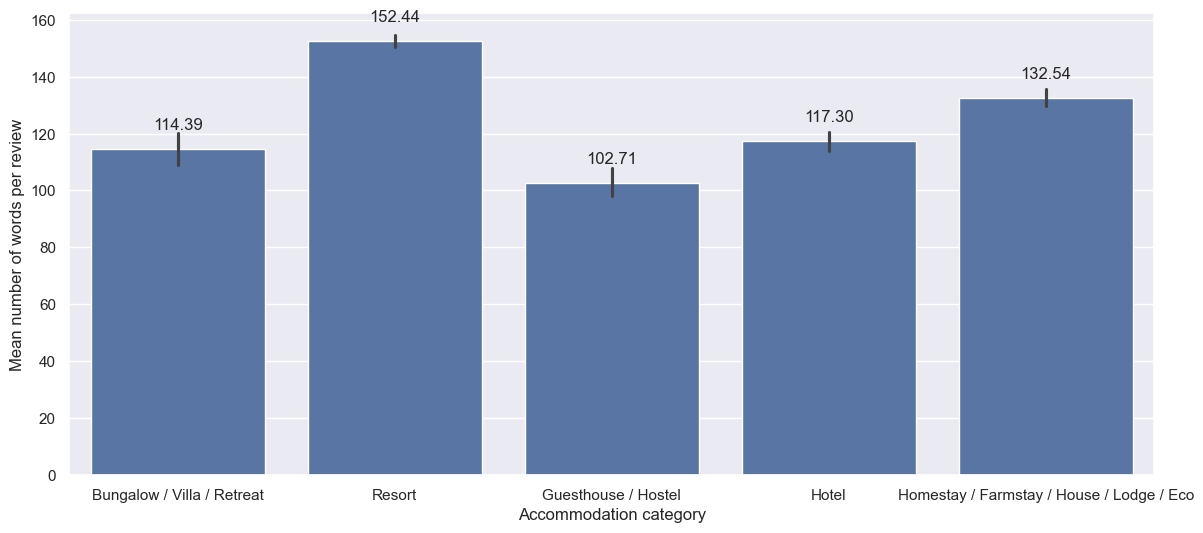

In [184]:
# Number of words by accommodation category
plt.figure(figsize=(14,6))
ax = sns.barplot(df, x="accom_type", y="no_words")
ax.set_ylabel('Mean number of words per review')
ax.set_xlabel('Accommodation category')
ax.bar_label(ax.containers[0], fontsize=12, label_type = 'edge', padding = 12, fmt = '{:.2f}')
plt.show()

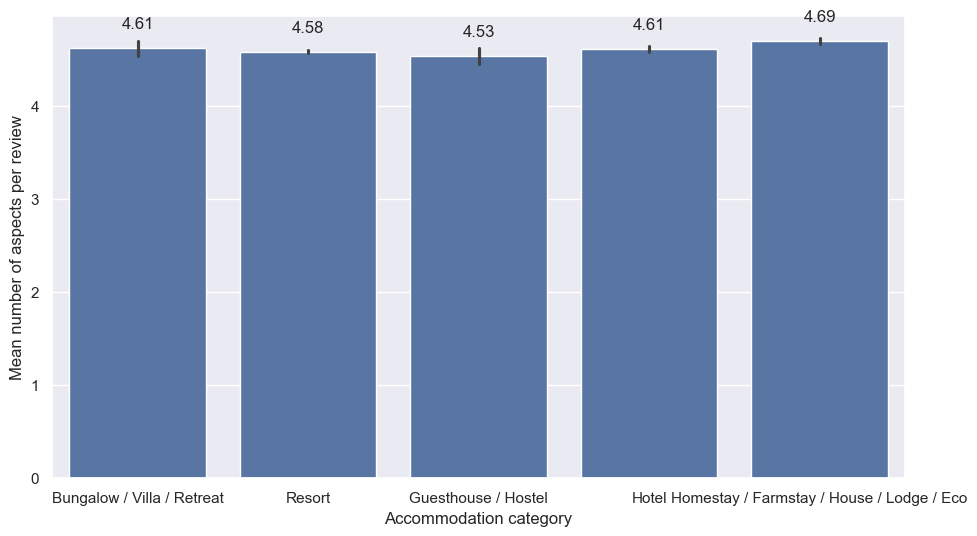

In [183]:
# Number of aspects by accommodation category
plt.figure(figsize=(11,6))
ax = sns.barplot(df, x="accom_type", y="aspect_no")
ax.set_ylabel('Mean number of aspects per review')
ax.set_xlabel('Accommodation category')
ax.bar_label(ax.containers[0], fontsize=12, label_type = 'edge', padding = 12, fmt = '{:.2f}')
plt.show()

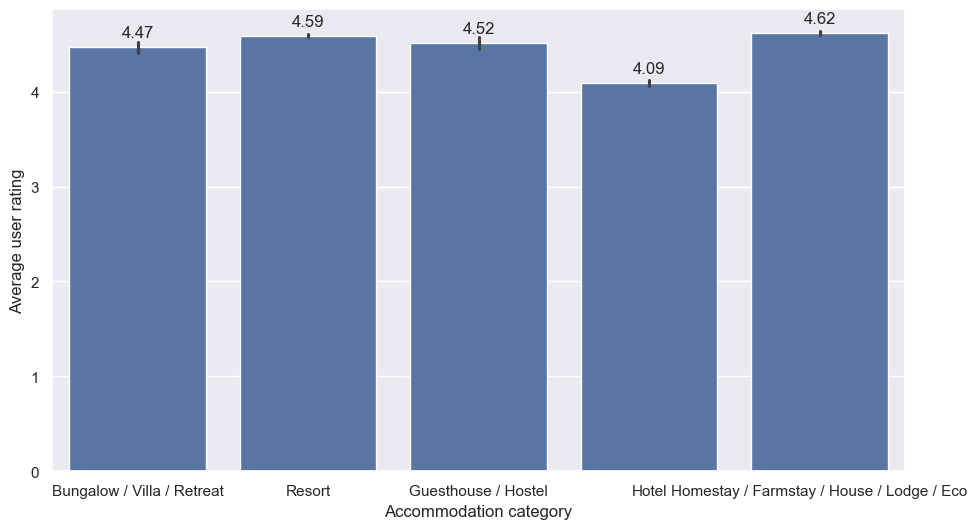

In [260]:
# User rating by accommodation category
plt.figure(figsize=(11,6))
ax = sns.barplot(df, x="accom_type", y="rating")
ax.set_ylabel('Average user rating')
ax.set_xlabel('Accommodation category')
ax.bar_label(ax.containers[0], fontsize=12, label_type = 'edge', padding = 5, fmt = '{:.2f}')
plt.show()

## 10 Most popular words per aspect

In [185]:
# create dictionary for aspect - a map of unique tokens
aspect_columns = list(aspect_df.aspect.unique())
aspect_columns = list(map(lambda x: x.lower(), aspect_columns))

for column in aspect_columns:
    print('\nAspect:', column)
    data = df[column][df[column] != 0]

    dictionary = Dictionary(data)

    # 100 tokens by frequency for cleaned up dictionary
    t_most_freq = dictionary.most_common(100)

    # Print info about top 20 tokens
    print('Top 20 tokens by frequency\n')
    num = 1
    for t, f in t_most_freq[:10]:
        print(str(num) + '.', t, '-', f)
        num = num + 1


Aspect: location
Top 20 tokens by frequency

1. place - 12458
2. beach - 11208
3. area - 6959
4. location - 4576
5. town - 3978
6. river - 3330
7. city - 3326
8. island - 2911
9. airport - 2618
10. garden - 2533

Aspect: cleanliness
Top 20 tokens by frequency

1. clean - 6656
2. room_clean - 1027
3. dirty - 680
4. well_maintain - 509
5. clean_room - 457
6. clean_comfortable - 315
7. immaculate - 288
8. pristine - 264
9. nice_clean - 257
10. tidy - 256

Aspect: comfort
Top 20 tokens by frequency

1. night - 8746
2. bed - 5467
3. relax - 4733
4. comfortable - 3383
5. quiet - 2736
6. cold - 1655
7. hot - 1604
8. sleep - 1397
9. rest - 1366
10. privacy - 916

Aspect: facilities
Top 20 tokens by frequency

1. room - 19883
2. resort - 19376
3. hotel - 18483
4. villa - 10702
5. pool - 9797
6. view - 5850
7. spa - 4636
8. bathroom - 4099
9. facility - 2882
10. shower - 2742

Aspect: service
Top 20 tokens by frequency

1. staff - 16107
2. service - 9927
3. experience - 7022
4. friendly - 5175
